In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
from transformers import RobertaTokenizer, ViTFeatureExtractor
from transformers.modeling_outputs import BaseModelOutput
from transformers import RobertaModel, ViTModel, T5ForConditionalGeneration
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

/home/ifscr/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2024-09-23 11:52:06.344021: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-23 11:52:06.353895: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-23 11:52:06.369809: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-23 11:52:06.374215: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-23 11:52:06.386256: I tensorflow/core/platform/cpu_featur

In [2]:
class MemeDataset(Dataset):
    def __init__(self, csv_file, csv_file2, image_dir, tokenizer, feature_extractor, max_text_length=128):
        """
        Args:
            csv_file (str): Path to the CSV file with image paths and LLaVA rationales.
            csv_file2 (str): Path to the CSV file with OCR text.
            image_dir (str): Directory with all the meme images.
            tokenizer (transformers tokenizer): Tokenizer for OCR text.
            feature_extractor (transformers feature extractor): Feature extractor for images.
            max_text_length (int): Maximum length for text tokens.
        """
        self.data = pd.read_csv(csv_file)  # CSV with image paths and rationales
        self.data2 = pd.read_csv(csv_file2)  # CSV with OCR text
        self.image_dir = image_dir
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.max_text_length = max_text_length
    
        self.label_mapping = {
            'not_offensive': 0,
            'slight': 1,
            'very_offensive': 2,
            'hateful_offensive': 3
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Extract relevant data using `idx`
        image_path = os.path.join(self.image_dir, str(self.data.iloc[idx]['image_path']))  # Get image path for idx
        ocr_text = str(self.data2.iloc[idx]['ocr'])  # Get OCR text for idx
        target_explanation = str(self.data.iloc[idx]['rationale'])  # Get LLaVA rationale for idx
        string_label = str(self.data2.iloc[idx]['offensive'])
        target = self.label_mapping[string_label]  # Map string label to int
        

        # Process image
        image = Image.open(image_path).convert("RGB")
        image = self.feature_extractor(images=image, return_tensors="pt")['pixel_values'].squeeze()

        # Process text (OCR text)
        text_encoding = self.tokenizer(
            ocr_text,
            padding='max_length',
            truncation=True,
            max_length=self.max_text_length,
            return_tensors="pt"
        )

        # Process target explanation (rationale)
        target_encoding = self.tokenizer(
            target_explanation,
            padding='max_length',
            truncation=True,
            max_length=self.max_text_length,
            return_tensors="pt"
        )

        return {
            'image': image,
            'ocr_text_input_ids': text_encoding['input_ids'].squeeze(),
            'ocr_text_attention_mask': text_encoding['attention_mask'].squeeze(),
            'target_ids': target_encoding['input_ids'].squeeze(),
            'target_attention_mask': target_encoding['attention_mask'].squeeze(),
            'labels': target
        }

# Example usage:
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
# dataset = MemeDataset('path_to_csv.csv', 'path_to_csv2.csv', 'path_to_images/', tokenizer, feature_extractor)
# dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
class MultimodalExplanationModel(nn.Module):
    def __init__(self, text_model_name='roberta-base', vision_model_name='google/vit-base-patch16-224', t5_model_name='t5-small'):
        super(MultimodalExplanationModel, self).__init__()
        self.device = device
        # Text and Vision encoders
        self.text_encoder = RobertaModel.from_pretrained(text_model_name).to(device)
        self.vision_encoder = ViTModel.from_pretrained(vision_model_name).to(device)
        
        # Decoder for generating explanations
        self.decoder = T5ForConditionalGeneration.from_pretrained(t5_model_name).to(device)

        # Linear layer to combine the two modalities
        self.fc = nn.Linear(self.text_encoder.config.hidden_size + self.vision_encoder.config.hidden_size, self.decoder.config.d_model).to(device)

    def forward(self, ocr_text_input_ids, ocr_text_attention_mask, image, target_ids=None, target_attention_mask=None):
    # Move inputs to the same device as the model (GPU if available)
        ocr_text_input_ids = ocr_text_input_ids.to(self.device)
        ocr_text_attention_mask = ocr_text_attention_mask.to(self.device)
        image = image.to(self.device)
        
        if target_ids is not None:
            target_ids = target_ids.to(self.device)
        if target_attention_mask is not None:
            target_attention_mask = target_attention_mask.to(self.device)
        
        # Textual features
        text_outputs = self.text_encoder(input_ids=ocr_text_input_ids, attention_mask=ocr_text_attention_mask)
        text_features = text_outputs.last_hidden_state[:, 0, :]  # Use the <s> token (CLS token) for classification

        # Visual features
        vision_outputs = self.vision_encoder(pixel_values=image)
        vision_features = vision_outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token for classification

        # Combine features
        combined_features = torch.cat((text_features, vision_features), dim=1)
        combined_features = self.fc(combined_features)

        # Repeat the combined features to create a pseudo-sequence
        repeated_features = combined_features.unsqueeze(1).repeat(1, target_ids.size(1), 1)  # Repeat along the sequence length

        # Generate explanation
        decoder_outputs = self.decoder(
            input_ids=target_ids,
            attention_mask=target_attention_mask,
            encoder_outputs=(repeated_features,),  # Pass the repeated features as the encoder output
            labels=target_ids
        )

        return decoder_outputs.loss, decoder_outputs.logits

In [5]:
%pip install sentencepiece

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [13]:
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
from transformers import T5Tokenizer

# Ensure the tokenizer is correctly set up
tokenizer = T5Tokenizer.from_pretrained('t5-small')

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = MultimodalExplanationModel().to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

# Data
dataset = MemeDataset('./DATA/scripts/rationale.csv','./DATA/scripts/train.csv', './DATA', tokenizer, feature_extractor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

/home/ifscr/.local/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# for batch in tqdm(dataloader):
#         optimizer.zero_grad()
        
#         # Get data
#         print(
#         ocr_text_input_ids = batch['ocr_text_input_ids'],
#         ocr_text_attention_mask = batch['ocr_text_attention_mask'],
#         image = batch['image'],
#         target_ids = batch['target_ids'],
#         )

**sample rationale**
Generated Explanation: Target Group or Person: The meme targets a specific individual, Narendra Modi, who is a political figure. It references his actions and the implication that he is not in a position of influence. Content Evaluation: The text is potentially offensive due to its reference to a political figure's actions and the use of a political figure to satirize the situation. Context and Implications: The context is political commentary on the political climate, which may be seen as a political commentary on the political climate. Overall Assessment: The meme uses humor to comment on political issues and political

In [14]:
val_dataset = MemeDataset('./DATA/scripts/val_rationale.csv','./DATA/scripts/val.csv', './DATA', tokenizer, feature_extractor)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [ ]:
# Training loop
model.train()
for epoch in range(1):  # Set the number of epochs
    epoch_loss = 0
    for batch in tqdm(dataloader):
        optimizer.zero_grad()
        
        # Get data
        ocr_text_input_ids = batch['ocr_text_input_ids'].to(device)
        ocr_text_attention_mask = batch['ocr_text_attention_mask'].to(device)
        image = batch['image'].to(device)
        target_ids = batch['target_ids'].to(device)
        target_attention_mask = batch['target_attention_mask'].to(device)
        
        # Forward pass
        loss, logits = model(
            ocr_text_input_ids=ocr_text_input_ids,
            ocr_text_attention_mask=ocr_text_attention_mask,
            image=image,
            target_ids=target_ids,
            target_attention_mask=target_attention_mask
        )
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Print training loss
    print(f"Epoch {epoch+1}/{50} - Loss: {epoch_loss/len(dataloader)}")

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    with torch.no_grad():  # Disable gradient calculation
        for val_batch in tqdm(val_dataloader):  # Assuming you have a validation dataloader
            # Get validation data
            ocr_text_input_ids = val_batch['ocr_text_input_ids'].to(device)
            ocr_text_attention_mask = val_batch['ocr_text_attention_mask'].to(device)
            image = val_batch['image'].to(device)
            target_ids = val_batch['target_ids'].to(device)
            target_attention_mask = val_batch['target_attention_mask'].to(device)
            
            # Forward pass for validation
            loss, _ = model(
                ocr_text_input_ids=ocr_text_input_ids,
                ocr_text_attention_mask=ocr_text_attention_mask,
                image=image,
                target_ids=target_ids,
                target_attention_mask=target_attention_mask
            )
            
            val_loss += loss.item()

    # Print validation loss
    print(f"Validation Loss after Epoch {epoch+1}: {val_loss/len(val_dataloader)}")
    
    model.train()  # Switch back to training mode


In [35]:
# Save the model
torch.save(model.state_dict(), 'multimodal_explanation_model_50.pth')
# Load the model
# model.load_state_dict(torch.load('multimodal_explanation_model.pth'))


In [6]:
model.load_state_dict(torch.load('multimodal_explanation_model_50.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [16]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params
    return total_params, trainable_params, non_trainable_params

# Get parameter counts
total_params, trainable_params, non_trainable_params = count_parameters(model)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

Total parameters: 272328448
Trainable parameters: 272328448
Non-trainable parameters: 0


In [ ]:
# dataset = MemeDataset('./DATA/scripts/rationale.csv','./DATA/scripts/train.csv', './DATA', tokenizer, feature_extractor)
# dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


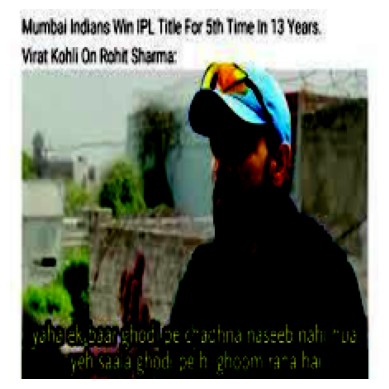

Generated Explanation: Target Group or Person: The meme targets a specific individual, Rohit Sharma, who is referred to as "Binod." It humorously compares his efforts to a particular individual's success in winning a competition. Content Evaluation: While the meme uses strong language and references to a particular individual's success, it is not overtly offensive in its intended context. The use of strong language and direct reference to another individual might be perceived as insensitive or disrespectful towards the individual depicted. Context and Implications: Without additional context, it's difficult to determine if


In [7]:

model.eval()
with torch.no_grad():
    for batch in dataloader:
        ocr_text_input_ids = batch['ocr_text_input_ids'].to(device)
        ocr_text_attention_mask = batch['ocr_text_attention_mask'].to(device)
        image = batch['image'].to(device)

        # Convert the tensor to a numpy array for visualization
        # Assuming the image tensor is in the format (N, C, H, W) and is normalized
        image_numpy = image[0].cpu().numpy().transpose(1, 2, 0)  # Change to (H, W, C)

        # If the image is normalized, you might want to denormalize it
        # This assumes your images were normalized to [0, 1] or mean/std of (0.5, 0.5, 0.5)
        # Uncomment and modify as necessary:
        # image_numpy = (image_numpy * 255).astype(np.uint8)

        # Display the image
        plt.imshow(image_numpy)
        plt.axis('off')  # Hide axes
        plt.show()

        # Get text and vision features
        text_features = model.text_encoder(ocr_text_input_ids, attention_mask=ocr_text_attention_mask).last_hidden_state[:, 0, :]
        vision_features = model.vision_encoder(pixel_values=image).last_hidden_state[:, 0, :]

        # Concatenate and pass through the linear layer
        combined_features = model.fc(torch.cat((text_features, vision_features), dim=1))

        # Repeat features to simulate sequence and wrap in BaseModelOutput
        repeated_features = combined_features.unsqueeze(1).repeat(1, 1, 1)
        encoder_outputs = BaseModelOutput(last_hidden_state=repeated_features)

        # Generate explanation using T5 generate method
        generated_ids = model.decoder.generate(
            input_ids=None,
            encoder_outputs=encoder_outputs,
            max_length=150
        )

        generated_explanation = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        print("Generated Explanation:", generated_explanation)
        break


In [17]:
# Define the classification layer (ensure this is done outside the loop, e.g., in the model definition)
class Classifier(nn.Module):
    def __init__(self, input_dim=512, num_classes=4):  # Assuming 2 classes: harmful and non-harmful
        super(Classifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        return self.fc(x)

# Initialize the classifier with the appropriate input dimension
# The input dimension should match the size of combined_features
classifier = Classifier().to(device)
# print(combined_features.shape[1])

In [18]:
otal_params, trainable_params, non_trainable_params = count_parameters(classifier)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

Total parameters: 272328448
Trainable parameters: 2052
Non-trainable parameters: 0


In [19]:
# Initialize the classifier, optimizer, and loss function
classifier = Classifier().to(device)
optimizer = optim.Adam(classifier.parameters(), lr=1e-3)  # Adjust learning rate as needed
loss_fn = nn.CrossEntropyLoss()  # Suitable for multi-class classification

# Training loop
num_epochs = 1  # Set number of epochs
classifier.train()  # Set the classifier to training mode

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Iterate over the dataloader
    for batch in tqdm(dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        optimizer.zero_grad()  # Clear gradients
        
        ocr_text_input_ids = batch['ocr_text_input_ids'].to(device)
        ocr_text_attention_mask = batch['ocr_text_attention_mask'].to(device)
        image = batch['image'].to(device)
        labels = batch['labels'].to(device)  # Ensure you have labels in your batch
        
        # Get text and vision features
        text_features = model.text_encoder(ocr_text_input_ids, attention_mask=ocr_text_attention_mask).last_hidden_state[:, 0, :]
        vision_features = model.vision_encoder(pixel_values=image).last_hidden_state[:, 0, :]
        
        # Concatenate features
        combined_features = model.fc(torch.cat((text_features, vision_features), dim=1))
        print(combined_features.shape)
        
        # Forward pass through the classifier
        classification_logits = classifier(combined_features)
        
        # Calculate loss
        loss = loss_fn(classification_logits, labels)
        running_loss += loss.item()
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        _, predicted = torch.max(classification_logits, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    # Print epoch statistics
    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = correct_predictions / total_samples
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")


Epoch 1/1:   0%|          | 0/219 [00:00<?, ?it/s]

torch.Size([32, 512])


Epoch 1/1:   0%|          | 1/219 [00:19<1:10:49, 19.49s/it]

torch.Size([32, 512])


Epoch 1/1:   1%|          | 2/219 [00:39<1:12:00, 19.91s/it]

torch.Size([32, 512])


Epoch 1/1:   1%|▏         | 3/219 [01:00<1:12:28, 20.13s/it]

torch.Size([32, 512])


Epoch 1/1:   2%|▏         | 4/219 [01:20<1:12:42, 20.29s/it]

torch.Size([32, 512])


Epoch 1/1:   2%|▏         | 5/219 [01:40<1:11:29, 20.04s/it]

torch.Size([32, 512])


Epoch 1/1:   3%|▎         | 6/219 [01:59<1:10:22, 19.82s/it]

torch.Size([32, 512])


Epoch 1/1:   3%|▎         | 7/219 [02:19<1:09:40, 19.72s/it]

torch.Size([32, 512])


Epoch 1/1:   4%|▎         | 8/219 [02:39<1:09:45, 19.83s/it]

torch.Size([32, 512])


Epoch 1/1:   4%|▍         | 9/219 [02:58<1:08:34, 19.60s/it]

torch.Size([32, 512])


Epoch 1/1:   5%|▍         | 10/219 [03:18<1:08:34, 19.69s/it]

torch.Size([32, 512])


Epoch 1/1:   5%|▌         | 11/219 [03:37<1:08:12, 19.68s/it]

torch.Size([32, 512])


Epoch 1/1:   5%|▌         | 12/219 [03:56<1:06:32, 19.29s/it]

torch.Size([32, 512])


Epoch 1/1:   6%|▌         | 13/219 [04:15<1:06:19, 19.32s/it]

torch.Size([32, 512])


Epoch 1/1:   6%|▋         | 14/219 [04:34<1:05:18, 19.11s/it]

torch.Size([32, 512])


Epoch 1/1:   7%|▋         | 15/219 [04:53<1:04:58, 19.11s/it]

torch.Size([32, 512])


Epoch 1/1:   7%|▋         | 16/219 [05:12<1:04:48, 19.15s/it]

torch.Size([32, 512])


Epoch 1/1:   8%|▊         | 17/219 [05:32<1:05:23, 19.42s/it]

torch.Size([32, 512])


Epoch 1/1:   8%|▊         | 18/219 [05:51<1:04:36, 19.29s/it]

torch.Size([32, 512])


Epoch 1/1:   9%|▊         | 19/219 [06:10<1:03:56, 19.18s/it]

torch.Size([32, 512])


Epoch 1/1:   9%|▉         | 20/219 [06:29<1:03:24, 19.12s/it]

torch.Size([32, 512])


Epoch 1/1:  10%|▉         | 21/219 [06:48<1:03:05, 19.12s/it]

torch.Size([32, 512])


Epoch 1/1:  10%|█         | 22/219 [07:09<1:04:12, 19.56s/it]

torch.Size([32, 512])


Epoch 1/1:  11%|█         | 23/219 [07:28<1:03:52, 19.55s/it]

torch.Size([32, 512])


Epoch 1/1:  11%|█         | 24/219 [07:47<1:02:22, 19.19s/it]

torch.Size([32, 512])


Epoch 1/1:  11%|█▏        | 25/219 [08:05<1:01:28, 19.01s/it]

torch.Size([32, 512])


Epoch 1/1:  12%|█▏        | 26/219 [08:24<1:00:52, 18.92s/it]

torch.Size([32, 512])


Epoch 1/1:  12%|█▏        | 27/219 [08:43<1:00:15, 18.83s/it]

torch.Size([32, 512])


Epoch 1/1:  13%|█▎        | 28/219 [09:02<1:00:44, 19.08s/it]

torch.Size([32, 512])


Epoch 1/1:  13%|█▎        | 29/219 [09:21<1:00:15, 19.03s/it]

torch.Size([32, 512])


Epoch 1/1:  14%|█▎        | 30/219 [09:40<59:38, 18.93s/it]  

torch.Size([32, 512])


Epoch 1/1:  14%|█▍        | 31/219 [09:59<59:17, 18.93s/it]

torch.Size([32, 512])


Epoch 1/1:  15%|█▍        | 32/219 [10:17<58:42, 18.84s/it]

torch.Size([32, 512])


Epoch 1/1:  15%|█▌        | 33/219 [10:36<58:12, 18.78s/it]

torch.Size([32, 512])


Epoch 1/1:  16%|█▌        | 34/219 [10:55<57:39, 18.70s/it]

torch.Size([32, 512])


Epoch 1/1:  16%|█▌        | 35/219 [11:14<57:56, 18.89s/it]

torch.Size([32, 512])


Epoch 1/1:  16%|█▋        | 36/219 [11:33<57:32, 18.86s/it]

torch.Size([32, 512])


Epoch 1/1:  17%|█▋        | 37/219 [11:52<57:27, 18.94s/it]

torch.Size([32, 512])


Epoch 1/1:  17%|█▋        | 38/219 [12:11<57:03, 18.91s/it]

torch.Size([32, 512])


Epoch 1/1:  18%|█▊        | 39/219 [12:29<56:30, 18.84s/it]

torch.Size([32, 512])


Epoch 1/1:  18%|█▊        | 40/219 [12:48<56:16, 18.86s/it]

torch.Size([32, 512])


Epoch 1/1:  19%|█▊        | 41/219 [13:08<56:50, 19.16s/it]

torch.Size([32, 512])


Epoch 1/1:  19%|█▉        | 42/219 [13:28<57:25, 19.46s/it]

torch.Size([32, 512])


Epoch 1/1:  20%|█▉        | 43/219 [14:01<1:08:41, 23.41s/it]

torch.Size([32, 512])


Epoch 1/1:  20%|██        | 44/219 [14:30<1:13:29, 25.20s/it]

torch.Size([32, 512])


Epoch 1/1:  21%|██        | 45/219 [14:57<1:14:08, 25.57s/it]

torch.Size([32, 512])


Epoch 1/1:  21%|██        | 46/219 [15:21<1:12:56, 25.30s/it]

torch.Size([32, 512])


Epoch 1/1:  21%|██▏       | 47/219 [15:49<1:14:19, 25.93s/it]

torch.Size([32, 512])


Epoch 1/1:  22%|██▏       | 48/219 [16:18<1:16:52, 26.97s/it]

torch.Size([32, 512])


Epoch 1/1:  22%|██▏       | 49/219 [16:51<1:21:05, 28.62s/it]

torch.Size([32, 512])


Epoch 1/1:  23%|██▎       | 50/219 [17:24<1:24:58, 30.17s/it]

torch.Size([32, 512])


Epoch 1/1:  23%|██▎       | 51/219 [17:57<1:26:33, 30.91s/it]

torch.Size([32, 512])


Epoch 1/1:  24%|██▎       | 52/219 [18:25<1:23:53, 30.14s/it]

torch.Size([32, 512])


Epoch 1/1:  24%|██▍       | 53/219 [18:54<1:22:15, 29.73s/it]

torch.Size([32, 512])


Epoch 1/1:  25%|██▍       | 54/219 [19:25<1:22:23, 29.96s/it]

torch.Size([32, 512])


Epoch 1/1:  25%|██▌       | 55/219 [19:55<1:21:51, 29.95s/it]

torch.Size([32, 512])


Epoch 1/1:  26%|██▌       | 56/219 [20:20<1:17:46, 28.63s/it]

torch.Size([32, 512])


Epoch 1/1:  26%|██▌       | 57/219 [20:47<1:16:14, 28.24s/it]

torch.Size([32, 512])


Epoch 1/1:  26%|██▋       | 58/219 [21:13<1:13:58, 27.57s/it]

torch.Size([32, 512])


Epoch 1/1:  27%|██▋       | 59/219 [21:41<1:13:46, 27.67s/it]

torch.Size([32, 512])


Epoch 1/1:  27%|██▋       | 60/219 [22:08<1:12:20, 27.30s/it]

torch.Size([32, 512])


Epoch 1/1:  28%|██▊       | 61/219 [22:28<1:06:37, 25.30s/it]

torch.Size([32, 512])


Epoch 1/1:  28%|██▊       | 62/219 [22:47<1:01:18, 23.43s/it]

torch.Size([32, 512])


Epoch 1/1:  29%|██▉       | 63/219 [23:06<57:16, 22.03s/it]  

torch.Size([32, 512])


Epoch 1/1:  29%|██▉       | 64/219 [23:25<54:21, 21.04s/it]

torch.Size([32, 512])


Epoch 1/1:  30%|██▉       | 65/219 [23:44<52:16, 20.37s/it]

torch.Size([32, 512])


Epoch 1/1:  30%|███       | 66/219 [24:03<50:42, 19.89s/it]

torch.Size([32, 512])


Epoch 1/1:  31%|███       | 67/219 [24:21<49:39, 19.60s/it]

torch.Size([32, 512])


Epoch 1/1:  31%|███       | 68/219 [24:40<48:30, 19.28s/it]

torch.Size([32, 512])


Epoch 1/1:  32%|███▏      | 69/219 [24:59<48:03, 19.22s/it]

torch.Size([32, 512])


Epoch 1/1:  32%|███▏      | 70/219 [25:18<47:20, 19.07s/it]

torch.Size([32, 512])


Epoch 1/1:  32%|███▏      | 71/219 [25:37<46:49, 18.98s/it]

torch.Size([32, 512])


Epoch 1/1:  33%|███▎      | 72/219 [25:55<46:22, 18.93s/it]

torch.Size([32, 512])


Epoch 1/1:  33%|███▎      | 73/219 [26:14<45:52, 18.85s/it]

torch.Size([32, 512])


Epoch 1/1:  34%|███▍      | 74/219 [26:33<45:18, 18.75s/it]

torch.Size([32, 512])


Epoch 1/1:  34%|███▍      | 75/219 [26:52<45:17, 18.87s/it]

torch.Size([32, 512])


Epoch 1/1:  35%|███▍      | 76/219 [27:11<44:56, 18.86s/it]

torch.Size([32, 512])


Epoch 1/1:  35%|███▌      | 77/219 [27:29<44:23, 18.76s/it]

torch.Size([32, 512])


Epoch 1/1:  36%|███▌      | 78/219 [27:48<44:19, 18.87s/it]

torch.Size([32, 512])


Epoch 1/1:  36%|███▌      | 79/219 [28:07<44:05, 18.90s/it]

torch.Size([32, 512])


Epoch 1/1:  37%|███▋      | 80/219 [28:26<43:44, 18.88s/it]

torch.Size([32, 512])


Epoch 1/1:  37%|███▋      | 81/219 [28:45<43:16, 18.82s/it]

torch.Size([32, 512])


Epoch 1/1:  37%|███▋      | 82/219 [29:03<42:57, 18.82s/it]

torch.Size([32, 512])


Epoch 1/1:  38%|███▊      | 83/219 [29:22<42:39, 18.82s/it]

torch.Size([32, 512])


Epoch 1/1:  38%|███▊      | 84/219 [29:41<42:21, 18.83s/it]

torch.Size([32, 512])


Epoch 1/1:  39%|███▉      | 85/219 [30:00<41:53, 18.76s/it]

torch.Size([32, 512])


Epoch 1/1:  39%|███▉      | 86/219 [30:19<41:36, 18.77s/it]

torch.Size([32, 512])


Epoch 1/1:  40%|███▉      | 87/219 [30:37<41:16, 18.76s/it]

torch.Size([32, 512])


Epoch 1/1:  40%|████      | 88/219 [30:56<41:06, 18.83s/it]

torch.Size([32, 512])


Epoch 1/1:  41%|████      | 89/219 [31:15<40:44, 18.80s/it]

torch.Size([32, 512])


Epoch 1/1:  41%|████      | 90/219 [31:34<40:23, 18.79s/it]

torch.Size([32, 512])


Epoch 1/1:  42%|████▏     | 91/219 [31:53<40:07, 18.81s/it]

torch.Size([32, 512])


Epoch 1/1:  42%|████▏     | 92/219 [32:11<39:45, 18.78s/it]

torch.Size([32, 512])


Epoch 1/1:  42%|████▏     | 93/219 [32:30<39:26, 18.78s/it]

torch.Size([32, 512])


Epoch 1/1:  43%|████▎     | 94/219 [32:49<39:14, 18.83s/it]

torch.Size([32, 512])


Epoch 1/1:  43%|████▎     | 95/219 [33:08<38:51, 18.80s/it]

torch.Size([32, 512])


Epoch 1/1:  44%|████▍     | 96/219 [33:26<38:23, 18.72s/it]

torch.Size([32, 512])


Epoch 1/1:  44%|████▍     | 97/219 [33:45<38:05, 18.73s/it]

torch.Size([32, 512])


Epoch 1/1:  45%|████▍     | 98/219 [34:04<37:41, 18.69s/it]

torch.Size([32, 512])


Epoch 1/1:  45%|████▌     | 99/219 [34:23<37:29, 18.74s/it]

torch.Size([32, 512])


Epoch 1/1:  46%|████▌     | 100/219 [34:41<36:57, 18.64s/it]

torch.Size([32, 512])


Epoch 1/1:  46%|████▌     | 101/219 [35:00<36:36, 18.62s/it]

torch.Size([32, 512])


Epoch 1/1:  47%|████▋     | 102/219 [35:18<36:13, 18.58s/it]

torch.Size([32, 512])


Epoch 1/1:  47%|████▋     | 103/219 [35:37<36:01, 18.63s/it]

torch.Size([32, 512])


Epoch 1/1:  47%|████▋     | 104/219 [35:56<35:46, 18.66s/it]

torch.Size([32, 512])


Epoch 1/1:  48%|████▊     | 105/219 [36:14<35:35, 18.73s/it]

torch.Size([32, 512])


Epoch 1/1:  48%|████▊     | 106/219 [36:33<35:14, 18.71s/it]

torch.Size([32, 512])


Epoch 1/1:  49%|████▉     | 107/219 [36:52<34:46, 18.63s/it]

torch.Size([32, 512])


Epoch 1/1:  49%|████▉     | 108/219 [37:10<34:30, 18.65s/it]

torch.Size([32, 512])


Epoch 1/1:  50%|████▉     | 109/219 [37:29<34:01, 18.56s/it]

torch.Size([32, 512])


Epoch 1/1:  50%|█████     | 110/219 [37:47<33:49, 18.62s/it]

torch.Size([32, 512])


Epoch 1/1:  51%|█████     | 111/219 [38:06<33:39, 18.70s/it]

torch.Size([32, 512])


Epoch 1/1:  51%|█████     | 112/219 [38:25<33:15, 18.65s/it]

torch.Size([32, 512])


Epoch 1/1:  52%|█████▏    | 113/219 [38:43<32:57, 18.66s/it]

torch.Size([32, 512])


Epoch 1/1:  52%|█████▏    | 114/219 [39:02<32:36, 18.64s/it]

torch.Size([32, 512])


Epoch 1/1:  53%|█████▎    | 115/219 [39:21<32:22, 18.68s/it]

torch.Size([32, 512])


Epoch 1/1:  53%|█████▎    | 116/219 [39:39<32:05, 18.69s/it]

torch.Size([32, 512])


Epoch 1/1:  53%|█████▎    | 117/219 [39:58<31:47, 18.70s/it]

torch.Size([32, 512])


Epoch 1/1:  54%|█████▍    | 118/219 [40:17<31:23, 18.65s/it]

torch.Size([32, 512])


Epoch 1/1:  54%|█████▍    | 119/219 [40:35<30:58, 18.59s/it]

torch.Size([32, 512])


Epoch 1/1:  55%|█████▍    | 120/219 [40:54<30:39, 18.58s/it]

torch.Size([32, 512])


Epoch 1/1:  55%|█████▌    | 121/219 [41:13<30:26, 18.64s/it]

torch.Size([32, 512])


Epoch 1/1:  56%|█████▌    | 122/219 [41:32<30:22, 18.79s/it]

torch.Size([32, 512])


Epoch 1/1:  56%|█████▌    | 123/219 [41:50<30:04, 18.79s/it]

torch.Size([32, 512])


Epoch 1/1:  57%|█████▋    | 124/219 [42:09<29:43, 18.77s/it]

torch.Size([32, 512])


Epoch 1/1:  57%|█████▋    | 125/219 [42:28<29:27, 18.81s/it]

torch.Size([32, 512])


Epoch 1/1:  58%|█████▊    | 126/219 [42:47<29:08, 18.80s/it]

torch.Size([32, 512])


Epoch 1/1:  58%|█████▊    | 127/219 [43:06<28:50, 18.81s/it]

torch.Size([32, 512])


Epoch 1/1:  58%|█████▊    | 128/219 [43:25<28:35, 18.85s/it]

torch.Size([32, 512])


Epoch 1/1:  59%|█████▉    | 129/219 [43:43<28:08, 18.76s/it]

torch.Size([32, 512])


Epoch 1/1:  59%|█████▉    | 130/219 [44:02<27:42, 18.67s/it]

torch.Size([32, 512])


Epoch 1/1:  60%|█████▉    | 131/219 [44:20<27:22, 18.67s/it]

torch.Size([32, 512])


Epoch 1/1:  60%|██████    | 132/219 [44:39<27:07, 18.70s/it]

torch.Size([32, 512])


Epoch 1/1:  61%|██████    | 133/219 [44:58<26:54, 18.77s/it]

torch.Size([32, 512])


Epoch 1/1:  61%|██████    | 134/219 [45:17<26:33, 18.75s/it]

torch.Size([32, 512])


Epoch 1/1:  62%|██████▏   | 135/219 [45:35<26:13, 18.73s/it]

torch.Size([32, 512])


Epoch 1/1:  62%|██████▏   | 136/219 [45:54<25:57, 18.77s/it]

torch.Size([32, 512])


Epoch 1/1:  63%|██████▎   | 137/219 [46:13<25:36, 18.74s/it]

torch.Size([32, 512])


Epoch 1/1:  63%|██████▎   | 138/219 [46:32<25:19, 18.76s/it]

torch.Size([32, 512])


Epoch 1/1:  63%|██████▎   | 139/219 [46:50<24:59, 18.75s/it]

torch.Size([32, 512])


Epoch 1/1:  64%|██████▍   | 140/219 [47:09<24:37, 18.70s/it]

torch.Size([32, 512])


Epoch 1/1:  64%|██████▍   | 141/219 [47:28<24:12, 18.63s/it]

torch.Size([32, 512])


Epoch 1/1:  65%|██████▍   | 142/219 [47:46<23:58, 18.68s/it]

torch.Size([32, 512])


Epoch 1/1:  65%|██████▌   | 143/219 [48:05<23:37, 18.65s/it]

torch.Size([32, 512])


Epoch 1/1:  66%|██████▌   | 144/219 [48:23<23:11, 18.55s/it]

torch.Size([32, 512])


Epoch 1/1:  66%|██████▌   | 145/219 [48:42<22:53, 18.56s/it]

torch.Size([32, 512])


Epoch 1/1:  67%|██████▋   | 146/219 [49:01<22:38, 18.61s/it]

torch.Size([32, 512])


Epoch 1/1:  67%|██████▋   | 147/219 [49:19<22:19, 18.60s/it]

torch.Size([32, 512])


Epoch 1/1:  68%|██████▊   | 148/219 [49:37<21:56, 18.54s/it]

torch.Size([32, 512])


Epoch 1/1:  68%|██████▊   | 149/219 [49:56<21:30, 18.44s/it]

torch.Size([32, 512])


Epoch 1/1:  68%|██████▊   | 150/219 [50:14<21:17, 18.52s/it]

torch.Size([32, 512])


Epoch 1/1:  69%|██████▉   | 151/219 [50:33<20:58, 18.51s/it]

torch.Size([32, 512])


Epoch 1/1:  69%|██████▉   | 152/219 [50:52<20:47, 18.62s/it]

torch.Size([32, 512])


Epoch 1/1:  70%|██████▉   | 153/219 [51:10<20:25, 18.56s/it]

torch.Size([32, 512])


Epoch 1/1:  70%|███████   | 154/219 [51:29<20:11, 18.64s/it]

torch.Size([32, 512])


Epoch 1/1:  71%|███████   | 155/219 [51:48<19:51, 18.62s/it]

torch.Size([32, 512])


Epoch 1/1:  71%|███████   | 156/219 [52:06<19:30, 18.58s/it]

torch.Size([32, 512])


Epoch 1/1:  72%|███████▏  | 157/219 [52:25<19:13, 18.61s/it]

torch.Size([32, 512])


Epoch 1/1:  72%|███████▏  | 158/219 [52:44<18:58, 18.67s/it]

torch.Size([32, 512])


Epoch 1/1:  73%|███████▎  | 159/219 [53:02<18:40, 18.67s/it]

torch.Size([32, 512])


Epoch 1/1:  73%|███████▎  | 160/219 [53:21<18:19, 18.63s/it]

torch.Size([32, 512])


Epoch 1/1:  74%|███████▎  | 161/219 [53:40<18:02, 18.67s/it]

torch.Size([32, 512])


Epoch 1/1:  74%|███████▍  | 162/219 [53:58<17:40, 18.60s/it]

torch.Size([32, 512])


Epoch 1/1:  74%|███████▍  | 163/219 [54:16<17:16, 18.51s/it]

torch.Size([32, 512])


Epoch 1/1:  75%|███████▍  | 164/219 [54:35<17:01, 18.57s/it]

torch.Size([32, 512])


Epoch 1/1:  75%|███████▌  | 165/219 [54:53<16:39, 18.51s/it]

torch.Size([32, 512])


Epoch 1/1:  76%|███████▌  | 166/219 [55:12<16:15, 18.41s/it]

torch.Size([32, 512])


Epoch 1/1:  76%|███████▋  | 167/219 [55:31<16:06, 18.58s/it]

torch.Size([32, 512])


Epoch 1/1:  77%|███████▋  | 168/219 [55:49<15:47, 18.58s/it]

torch.Size([32, 512])


Epoch 1/1:  77%|███████▋  | 169/219 [56:08<15:29, 18.60s/it]

torch.Size([32, 512])


Epoch 1/1:  78%|███████▊  | 170/219 [56:26<15:09, 18.57s/it]

torch.Size([32, 512])


Epoch 1/1:  78%|███████▊  | 171/219 [56:45<14:50, 18.55s/it]

torch.Size([32, 512])


Epoch 1/1:  79%|███████▊  | 172/219 [57:03<14:33, 18.60s/it]

torch.Size([32, 512])


Epoch 1/1:  79%|███████▉  | 173/219 [57:22<14:16, 18.62s/it]

torch.Size([32, 512])


Epoch 1/1:  79%|███████▉  | 174/219 [57:41<13:59, 18.65s/it]

torch.Size([32, 512])


Epoch 1/1:  80%|███████▉  | 175/219 [57:59<13:38, 18.61s/it]

torch.Size([32, 512])


Epoch 1/1:  80%|████████  | 176/219 [58:18<13:20, 18.61s/it]

torch.Size([32, 512])


Epoch 1/1:  81%|████████  | 177/219 [58:37<13:05, 18.70s/it]

torch.Size([32, 512])


Epoch 1/1:  81%|████████▏ | 178/219 [58:55<12:42, 18.59s/it]

torch.Size([32, 512])


Epoch 1/1:  82%|████████▏ | 179/219 [59:14<12:23, 18.58s/it]

torch.Size([32, 512])


Epoch 1/1:  82%|████████▏ | 180/219 [59:32<12:04, 18.57s/it]

torch.Size([32, 512])


Epoch 1/1:  83%|████████▎ | 181/219 [59:51<11:44, 18.55s/it]

torch.Size([32, 512])


Epoch 1/1:  83%|████████▎ | 182/219 [1:00:09<11:26, 18.55s/it]

torch.Size([32, 512])


Epoch 1/1:  84%|████████▎ | 183/219 [1:00:28<11:07, 18.53s/it]

torch.Size([32, 512])


Epoch 1/1:  84%|████████▍ | 184/219 [1:00:46<10:48, 18.53s/it]

torch.Size([32, 512])


Epoch 1/1:  84%|████████▍ | 185/219 [1:01:05<10:31, 18.58s/it]

torch.Size([32, 512])


Epoch 1/1:  85%|████████▍ | 186/219 [1:01:23<10:09, 18.48s/it]

torch.Size([32, 512])


Epoch 1/1:  85%|████████▌ | 187/219 [1:01:42<09:51, 18.50s/it]

torch.Size([32, 512])


Epoch 1/1:  86%|████████▌ | 188/219 [1:02:00<09:34, 18.53s/it]

torch.Size([32, 512])


Epoch 1/1:  86%|████████▋ | 189/219 [1:02:19<09:16, 18.54s/it]

torch.Size([32, 512])


Epoch 1/1:  87%|████████▋ | 190/219 [1:02:37<08:54, 18.44s/it]

torch.Size([32, 512])


Epoch 1/1:  87%|████████▋ | 191/219 [1:02:56<08:35, 18.41s/it]

torch.Size([32, 512])


Epoch 1/1:  88%|████████▊ | 192/219 [1:03:14<08:19, 18.50s/it]

torch.Size([32, 512])


Epoch 1/1:  88%|████████▊ | 193/219 [1:03:33<08:01, 18.50s/it]

torch.Size([32, 512])


Epoch 1/1:  89%|████████▊ | 194/219 [1:03:51<07:42, 18.50s/it]

torch.Size([32, 512])


Epoch 1/1:  89%|████████▉ | 195/219 [1:04:10<07:23, 18.48s/it]

torch.Size([32, 512])


Epoch 1/1:  89%|████████▉ | 196/219 [1:04:28<07:06, 18.54s/it]

torch.Size([32, 512])


Epoch 1/1:  90%|████████▉ | 197/219 [1:04:47<06:47, 18.53s/it]

torch.Size([32, 512])


Epoch 1/1:  90%|█████████ | 198/219 [1:05:05<06:28, 18.51s/it]

torch.Size([32, 512])


Epoch 1/1:  91%|█████████ | 199/219 [1:05:24<06:10, 18.50s/it]

torch.Size([32, 512])


Epoch 1/1:  91%|█████████▏| 200/219 [1:05:42<05:50, 18.46s/it]

torch.Size([32, 512])


Epoch 1/1:  92%|█████████▏| 201/219 [1:06:01<05:31, 18.43s/it]

torch.Size([32, 512])


Epoch 1/1:  92%|█████████▏| 202/219 [1:06:19<05:15, 18.54s/it]

torch.Size([32, 512])


Epoch 1/1:  93%|█████████▎| 203/219 [1:06:38<04:56, 18.53s/it]

torch.Size([32, 512])


Epoch 1/1:  93%|█████████▎| 204/219 [1:06:57<04:38, 18.59s/it]

torch.Size([32, 512])


Epoch 1/1:  94%|█████████▎| 205/219 [1:07:15<04:21, 18.67s/it]

torch.Size([32, 512])


Epoch 1/1:  94%|█████████▍| 206/219 [1:07:34<04:01, 18.58s/it]

torch.Size([32, 512])


Epoch 1/1:  95%|█████████▍| 207/219 [1:07:52<03:41, 18.47s/it]

torch.Size([32, 512])


Epoch 1/1:  95%|█████████▍| 208/219 [1:08:11<03:23, 18.51s/it]

torch.Size([32, 512])


Epoch 1/1:  95%|█████████▌| 209/219 [1:08:29<03:05, 18.53s/it]

torch.Size([32, 512])


Epoch 1/1:  96%|█████████▌| 210/219 [1:08:48<02:46, 18.48s/it]

torch.Size([32, 512])


Epoch 1/1:  96%|█████████▋| 211/219 [1:09:06<02:28, 18.51s/it]

torch.Size([32, 512])


Epoch 1/1:  97%|█████████▋| 212/219 [1:09:25<02:09, 18.51s/it]

torch.Size([32, 512])


Epoch 1/1:  97%|█████████▋| 213/219 [1:09:43<01:51, 18.51s/it]

torch.Size([32, 512])


Epoch 1/1:  98%|█████████▊| 214/219 [1:10:02<01:32, 18.55s/it]

torch.Size([32, 512])


Epoch 1/1:  98%|█████████▊| 215/219 [1:10:20<01:14, 18.57s/it]

torch.Size([32, 512])


Epoch 1/1:  99%|█████████▊| 216/219 [1:10:39<00:55, 18.59s/it]

torch.Size([32, 512])


Epoch 1/1:  99%|█████████▉| 217/219 [1:10:58<00:37, 18.60s/it]

torch.Size([32, 512])


Epoch 1/1: 100%|█████████▉| 218/219 [1:11:16<00:18, 18.58s/it]

torch.Size([24, 512])


Epoch 1/1: 100%|██████████| 219/219 [1:11:30<00:00, 19.59s/it]

Epoch [1/1], Loss: 0.9922, Accuracy: 0.6037


In [ ]:
# Save the model after training
torch.save(classifier.state_dict(), 'classifier_model.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


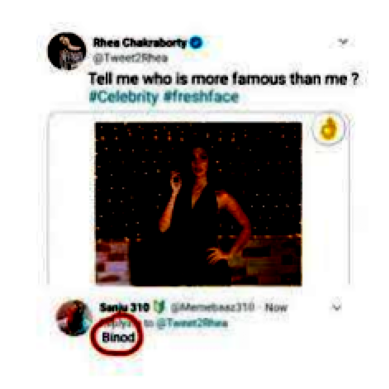

torch.Size([8, 512])
Generated Explanation: sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss sssssssssssssssssssssssssssssssssss
Predicted Class: hateful_offensive


In [29]:
model.eval()
classifier.eval()
with torch.no_grad():
    for batch in dataloader:
        ocr_text_input_ids = batch['ocr_text_input_ids'].to(device)
        ocr_text_attention_mask = batch['ocr_text_attention_mask'].to(device)
        image = batch['image'].to(device)

        # Convert the tensor to a numpy array for visualization
        image_numpy = image[0].cpu().numpy().transpose(1, 2, 0)

        # Display the image
        plt.imshow(image_numpy)
        plt.axis('off')  # Hide axes
        plt.show()

        # Get text and vision features
        text_features = model.text_encoder(ocr_text_input_ids, attention_mask=ocr_text_attention_mask).last_hidden_state[:, 0, :]
        vision_features = model.vision_encoder(pixel_values=image).last_hidden_state[:, 0, :]

        # Concatenate and pass through the linear layer
        combined_features = model.fc(torch.cat((text_features, vision_features), dim=1))
        print(combined_features.shape)

        # Repeat features to simulate sequence and wrap in BaseModelOutput
        repeated_features = combined_features.unsqueeze(1).repeat(1, 1, 1)
        encoder_outputs = BaseModelOutput(last_hidden_state=repeated_features)

        # Generate explanation using T5 generate method
        generated_ids = model.decoder.generate(
            input_ids=None,
            encoder_outputs=encoder_outputs,
            max_length=150
        )

        generated_explanation = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        print("Generated Explanation:", generated_explanation)

        # Use the combined features for classification
        classification_logits = classifier(combined_features)

        # Apply softmax to get probabilities
        classification_probs = nn.functional.softmax(classification_logits, dim=1)

        # Get predicted class
        predicted_class = torch.argmax(classification_probs, dim=1)
        # class_labels = ['non-harmful', 'harmful']  # Adjust according to your label encoding
        class_labels = ['not_offensive','slight','very_offensive','hateful_offensive']

        # print(predicted_class)
        print("Predicted Class:", class_labels[predicted_class[0]])

        # for idx, predicted in enumerate(predicted_class):
        #     print(f"Predicted Class for item {idx}: {class_labels[predicted.item()]}")
        break
